# Prosjekt Del 1

## Laster inn moduler 

In [795]:
#SJEKK OM ALLE MODULENE ER LOVLIGE I OPPGAVEBESKRIVELSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


## Innstillinger for å få en mer omfattende visning av alle dataframene

In [796]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.expand_frame_repr", False)

## Laster inn filer (rådata)

In [797]:
demographic_df = pd.read_csv("./raw_data/demographic.csv")
hospital_df = pd.read_csv("./raw_data/hospital.csv")
phychological_df = pd.read_csv("./raw_data/physiological.txt", sep="\t")
severity_df = pd.read_json("./raw_data/severity.json")

In [798]:
phychological_df.head()

,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,43.0,17.097656,112.0,34.0,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,70.0,8.500000,88.0,28.0,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
3,5,59.0,13.500000,112.0,20.0,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN
4,6,110.0,10.398438,101.0,44.0,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN


## Analyserer dataframene for misvisende informasjon som må håndteres

## Begynner med demographic data


Mesteparten av informasjonen i demographic data viser seg å være oversiktelig og forståelig. Vi merker oss at vi har NaN (Not a Number) verdier. Dette kan hinte til pasienten har ufullstendig registrering. Seinere kan det bli aktuelt å fylle manglende verdier med ved hjelp av statistiske metoder.

In [799]:
demographic_df.shape

(7742, 6)

In [800]:
demographic_df.head()

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet
0,2,60.33899,female,12.0,$11-$25k,white
1,3,52.74698,female,12.0,under $11k,white
2,4,42.38498,female,11.0,under $11k,white
3,5,79.88495,female,NaN,NaN,white
4,6,93.01599,male,14.0,NaN,white


## Hospital data

I hospital_df oppdager vi et bemerkelsesverdig resultat: Det finnes en negativ verdi for oppholdslengden (-99). Dette er selvsagt ikke mulig, ettersom det ikke er fysisk mulig å oppholde seg på sykehuset i et negativt tidsrom.

In [801]:
hospital_df.shape

(7740, 3)

In [802]:
hospital_df.head()

,pasient_id,sykehusdød,oppholdslengde
0,2,1,4
1,3,0,17
2,4,0,3
3,5,0,-99
4,6,1,4


## Håndtering av manglende fysiologiske data

I den fysiologiske dataframen er det en betydelig forekomst av NaN-verdier. Disse manglende verdiene kan skape problemer i senere faser når vi skal utvikle modeller og gjøre prediksjoner. For å unngå å ekskludere personer fra datasettet, har jeg besluttet å erstatte NaN-verdiene med eksempelverdier. De anbefalte eksempelverdiene er hentet fra: https://archive.ics.uci.edu/dataset/880/support2


In [803]:
nan_values = phychological_df.isna().sum()
print(nan_values)

pasient_id                 0
blodtrykk                  0
hvite_blodlegemer        175
hjertefrekvens             0
respirasjonsfrekvens       0
kroppstemperatur           0
lungefunksjon           1944
serumalbumin            2849
bilirubin               2196
kreatinin                 57
natrium                    0
blod_ph                 1912
glukose                 3823
blodurea_nitrogen       3692
urinmengde              4113
dtype: int64


In [804]:
phychological_df["serumalbumin"].fillna(3.5,inplace=True)
phychological_df["bilirubin"].fillna(1.01,inplace=True)
phychological_df["kreatinin"].fillna(1.01,inplace=True) # creatinine (crea)
phychological_df["hvite_blodlegemer"].fillna(9,inplace=True) # white bloog count
phychological_df["urinmengde"].fillna(2502,inplace=True) # urine output (urine)

C:\Users\andre\AppData\Local\Temp\ipykernel_25196\813871059.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\andre\AppData\Local\Temp\ipykernel_25196\813871059.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

## Håndtering av .json fil (Serverity data)

Denne filen kommer i et annet format, der alle kolonnene utenom de to første er lister. For å kunne slå sammen alle DataFrame-ene til én felles DataFrame, er det nødvendig at alle har samme format. Derfor velger jeg å bruke explode(). Når jeg bruker explode() på en kolonne, vil hver verdi i listen bli plassert i sin egen rad, mens de andre kolonneverdiene i samme rad forblir uendret. Dette betyr at h\for hver listeverdi i en olnne vil det opprettes en ny rad, noe som effektivt "utvider" Dataframen. Dette trinnet er avgjørende for å forbedre dataene for videre behandling, som for eksempel modellering og statistisk analyse

In [805]:
severity_df.head()

,sykdomskategori_id,sykdomskategori,pasient_id,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,A1s,ARF/MOSF,"[5, 15, 18, 23, 28, 34, 39, 43, 46, 47, 48, 58...","[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, ...","[ARF/MOSF w/Sepsis, ARF/MOSF w/Sepsis, ARF/MOS...","[1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 3, 1, 3, ...","[26.0, 26.0, 26.0, 0.0, 26.0, 37.0, 0.0, 0.0, ...","[None, None, None, None, None, None, None, Non...","[2.0, None, 0.0, 5.0, 2.0, None, 0.0, None, No...","[23.5, 30.5, 40.296875, 31.6992188, 46.796875,...","[30.0, 39.0, 58.0, 42.0, 85.0, 49.0, 5.0, 76.0...","[0.6348876950000001, 0.590942383, 0.2129821780...","[0.5329589840000001, 0.481994629, 0.1169891360...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, yes, no, no, no, no, no, yes,...","[0.899999619, 0.899999619, 0.09999996400000001...","[0.9, 0.9, 0.001, 0.5, 0.000125, 0.60000000000...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
1,BrY,COPD/CHF/Cirrhosis,"[2, 3, 7, 8, 11, 13, 14, 19, 20, 30, 31, 32, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[Cirrhosis, Cirrhosis, CHF, CHF, CHF, Cirrhosi...","[2, 2, 1, 3, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1, ...","[44.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[None, 1.0, 0.0, None, 2.0, 0.0, 0.0, 7.0, 3.0...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 7.0, None,...","[52.6953125, 20.5, 17.296875, 21.5976562, 14.5...","[74.0, 45.0, 46.0, 53.0, 14.0, 30.0, 34.0, 42....","[0.000999928, 0.790893555, 0.892944336, 0.6708...","[0.0, 0.6649169920000001, 0.820922852, 0.49896...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, no, no, no, no, no, no, no, n...","[0.0, 0.75, None, 0.799999714, 0.699999809, No...","[0.0, 0.5, 0.7000000000000001, 0.4, 0.5, None,...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non..."
2,ChE,Cancer,"[4, 9, 10, 12, 16, 17, 21, 24, 27, 41, 42, 54,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[Lung Cancer, Lung Cancer, Colon Cancer, Lung ...","[2, 2, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 0, 1, ...","[0.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0...","[0.0, None, 0.0, 1.0, 2.0, None, 0.0, None, No...","[0.0, 7.0, None, 1.0, 0.0, None, 0.0, None, No...","[20.0976562, 15.8984375, 2.2998047, 16.3984375...","[19.0, 17.0, 9.0, 17.0, 11.0, 4.0, 16.0, 11.0,...","[0.6989746090000001, 0.570922852, 0.9528808590...","[0.411987305, 0.24899292, 0.8879394530000001, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[metastatic, metastatic, metastatic, metastati...","[0.899999619, 0.049999982000000005, None, None...","[0.5, 0.000125, None, None, 0.7000000000000001...","[None, dnr ved innleggelse, None, None, None, ...","[None, 0.0, None, None, None, None, None, None..."
3,DWw,Coma,"[6, 162, 188, 250, 252, 262, 275, 309, 323, 35...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[Coma, Coma, Coma, Coma, Coma, Coma, Coma, Com...","[1, 0, 0, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 2, 0, ...","[55.0, 61.0, 94.0, 55.0, 94.0, 100.0, 100.0, 5...","[None, None, None, None, None, None, None, Non...","[1.0, None, None, 1.0, None, None, None, None,...","[19.3984375, 30.3984375, 20.296875, 30.8984375...","[27.0, 36.0, 22.0, 53.0, 40.0, 25.0, 58.0, 16....","[0.28497314500000004, 0.438964844, 0.280944824...","[0.214996338, 0.365966797, 0.211975098, 0.2729...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[no, no, no, no, yes, no, no, no, no, no, no, ...","[0.0, None, None, None, None, 0.09999996400000...","[0.0, None, N

## Kommentar etter bruk av explode() på df_severity

Dataen ser fin og oversiktelig ut. Inneholder rikelig med binære verdier. Binære verdier er ideelt for modelleringen som skal gjøres i del 2. Dette fordi binære verdier gir enkelhet, effektivitet og klare klassifiseringsmuligheter.

In [806]:
columns_to_list = severity_df.columns.to_list()
valid_columns = columns_to_list[2:]
severity_df = severity_df.explode(valid_columns, ignore_index=True)

In [807]:
severity_df.head()

,sykdomskategori_id,sykdomskategori,pasient_id,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,A1s,ARF/MOSF,5,0,ARF/MOSF w/Sepsis,1,26.0,None,2.0,23.5,30.0,0.634888,0.532959,0,0,no,0.9,0.9,None,None
1,A1s,ARF/MOSF,15,0,ARF/MOSF w/Sepsis,1,26.0,None,None,30.5,39.0,0.590942,0.481995,0,0,no,0.9,0.9,None,None
2,A1s,ARF/MOSF,18,1,ARF/MOSF w/Sepsis,0,26.0,None,0.0,40.296875,58.0,0.212982,0.116989,0,0,no,0.1,0.001,None,None
3,A1s,ARF/MOSF,23,0,ARF/MOSF w/Sepsis,1,0.0,None,5.0,31.699219,42.0,0.650879,0.55188,0,0,no,0.6,0.5,None,None
4,A1s,ARF/MOSF,28,1,MOSF w/Malig,1,26.0,None,2.0,46.796875,85.0,0.021,0.004999,0,0,yes,0.05,0.000125,None,None


## Slår alle dataframene sammen i et felles datasett. 

For at det skal være mulig å slå dataframene sammen ved hjelp av concat() er det nødvendig at alle dataframene har likt antall rader. Hvis ikke kan analyse føre til uventede resultater, som duplikater eller manglende data

In [808]:
demographic_df = demographic_df.drop_duplicates() # vi fjerner duplikater i demographic data før vi kan slå dataframene sammen

print('Demographic data:', demographic_df.shape)
print('Hospital data:', hospital_df.shape)
print('Physiological data:', phychological_df.shape)
print('Severity data:', severity_df.shape)

Demographic data: (7740, 6)
Hospital data: (7740, 3)
Physiological data: (7740, 15)
Severity data: (7740, 20)


In [809]:
demographic_df = demographic_df.reset_index(drop=True)
hospital_df = hospital_df.reset_index(drop=True).drop(columns=['pasient_id'])
phychological_df = phychological_df.reset_index(drop=True).drop(columns=['pasient_id'])
severity_df = severity_df.reset_index(drop=True).drop(columns=['pasient_id'])

df = pd.concat([demographic_df, hospital_df, phychological_df, severity_df], axis=1)

In [810]:
df.describe()

,pasient_id,alder,utdanning,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
count,7740.000000,7740.000000,6359.000000,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,7740.000000,5796.000000,7740.000000,7740.000000,7740.000000,7740.000000,5828.000000,3917.000000,4048.000000,7740.000000
mean,4540.665375,62.712258,11.753106,0.263178,17.728682,84.412468,12.227368,97.283940,23.348450,37.116579,239.608379,3.154105,2.124243,1.784532,137.574160,7.415439,160.031146,32.582040,2353.639005
std,2636.463416,15.688039,3.458930,0.440387,21.995401,27.713746,9.017879,31.499505,9.549561,1.257278,109.942808,0.754716,4.555226,1.706914,6.029887,0.080844,87.828819,26.826593,1011.035013
min,2.000000,-1.000000,0.000000,0.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,31.699220,12.000000,0.399963,0.099991,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000
25%,2244.750000,52.921740,10.000000,0.000000,6.000000,63.000000,7.000000,72.000000,18.000000,36.195310,155.093750,2.699707,0.599976,0.899902,134.000000,7.379883,103.000000,14.000000,2050.000000
50%,4539.500000,65.008000,12.000000,0.000000,11.000000,77.000000,10.398438,100.000000,24.000000,36.695310,223.984375,3.500000,1.010000,1.199951,137.000000,7.419922,135.000000,23.000000,2502.000000
75%,6816.250000,74.133747,14.000000,1.000000,20.000000,107.000000,15.099609,120.000000,28.000000,38.195310,304.750000,3.500000,1.299805,1.899902,141.000000,7.469727,190.000000,43.000000,2502.000000
max,9105.000000,101.847960,31.000000,1.000000,343.000000,195.000000,128.781250,232.000000,90.000000,41.695310,869.375000,29.000000,63.000000,21.500000,181.000000,7.769531,1092.000000,192.000000,9000.000000


#### Databehandling

Å konvertere kolonner fra objekt til numerisk format er en viktig del av datarengjøring og forberedelse før analysering og modellering. Det sikrer at dataene er i et format som kan brukes effektivt og korrekt av maskinlæringsalgoritmer og statistiske analyser.

In [811]:
df[['dødsfall','antall_komorbiditeter' ,'koma_score' ,'adl_pasient' ,'adl_stedfortreder' ,'fysiologisk_score' ,'apache_fysiologisk_score', 'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd','diabetes', 'demens', 'lege_overlevelsesestimat_2mnd','lege_overlevelsesestimat_6mnd', 'dnr_dag']] = df[['dødsfall', 'antall_komorbiditeter', 'koma_score', 'adl_pasient', 'adl_stedfortreder', 'fysiologisk_score','apache_fysiologisk_score' ,'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd','diabetes', 'demens','lege_overlevelsesestimat_2mnd','lege_overlevelsesestimat_6mnd', 'dnr_dag']].apply(pd.to_numeric)

#### Ser på verdier som ikke gir mening

In [812]:
negativ_oppholdslengde = df[df["oppholdslengde"] < 0]
negativ_oppholdslengde

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
3,5,79.88495,female,NaN,NaN,white,0,-99,59.0,13.500000,112.0,20.0,37.89844,173.31250,3.500000,1.010000,0.799927,143.0,7.509766,NaN,NaN,2502.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,0.0,NaN,5.0,31.699219,42.0,0.650879,0.551880,0,0,no,0.60,0.50,None,NaN
20,23,49.61298,female,12.0,$25-$50k,white,0,-99,67.0,11.000000,120.0,48.0,38.89844,200.00000,2.000000,4.099609,0.599976,130.0,7.399414,NaN,NaN,2502.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,2,100.0,NaN,NaN,54.898438,80.0,0.000000,0.000000,0,0,metastatic,NaN,NaN,None,NaN
83,102,72.39697,female,10.0,NaN,black,0,-99,115.0,6.599609,104.0,20.0,37.29688,460.00000,3.500000,1.010000,2.299805,138.0,7.549805,NaN,NaN,2502.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,0,0.0,NaN,3.0,36.195312,72.0,0.743896,0.662964,0,0,no,0.02,0.02,None,NaN
216,256,54.18198,male,17.0,>$50k,white,1,-99,60.0,4.500000,190.0,40.0,39.50000,90.00000,1.699951,0.500000,1.199951,130.0,7.309570,NaN,NaN,2502.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,2,41.0,NaN,NaN,33.796875,50.0,0.631958,0.529907,0,0,no,0.50,0.50,None,NaN
438,508,63.25000,male,13.0,$25-$50k,asian,0,-99,87.0,11.199219,100.0,30.0,38.00000,NaN,4.599609,0.500000,0.899902,134.0,NaN,NaN,NaN,2502.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,1,26.0,NaN,NaN,23.500000,41.0,0.806885,0.742920,1,0,no,0.90,0.85,None,NaN
6802,8000,82.05298,female,10.0,under $11k,white,0,-99,74.0,12.699219,120.0,36.0,39.69531,187.09375,3.299805,0.799927,1.199951,137.0,7.439453,NaN,NaN,2502.0,ChE,Cancer,1,Colon Cancer,1,0.0,2.0,1.0,27.898438,30.0,0.605957,0.288940,0,0,metastatic,0.80,0.10,None,NaN


In [813]:
negativ_alder = df[df["alder"] < 0]
negativ_alder

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
13,15,-1.0,female,NaN,NaN,white,0,115,67.0,24.597656,172.0,20.0,38.79688,113.32812,3.500000,1.01,0.599976,134.0,7.399414,NaN,NaN,2502.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,26.0,NaN,NaN,24.699219,29.0,0.617920,0.512939,0,0,no,0.8,0.800,None,NaN
93,112,-1.0,female,12.0,under $11k,white,1,4,66.0,18.898438,130.0,30.0,37.69531,81.32812,2.299805,10.50,0.799927,143.0,7.459961,NaN,NaN,2502.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,1,0.0,NaN,NaN,16.398438,42.0,0.823975,0.764893,0,0,no,0.4,0.300,None,NaN
219,259,-1.0,male,13.0,NaN,NaN,0,6,66.0,4.899414,80.0,24.0,36.69531,NaN,3.500000,1.01,1.399902,134.0,NaN,NaN,NaN,2502.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,2,41.0,NaN,NaN,28.199219,39.0,0.472961,0.353943,0,0,no,0.1,0.001,None,NaN
359,421,-1.0,male,NaN,NaN,black,0,7,88.0,5.899414,114.0,22.0,37.39844,NaN,3.500000,1.01,1.010000,139.0,NaN,NaN,NaN,2502.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,0.0,NaN,NaN,15.798828,25.0,0.872925,0.828979,0,0,no,0.6,0.300,None,NaN
868,1002,-1.0,male,12.0,$25-$50k,black,1,5,55.0,11.898438,100.0,32.0,38.39844,131.65625,3.500000,1.01,7.500000,146.0,7.449219,199.0,65.0,753.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,6,0.0,0.0,NaN,21.296875,32.0,0.779907,0.707886,1,0,no,0.8,0.200,None,NaN


In [814]:
df = df[df["oppholdslengde"] >= 0]
df = df[df["alder"] >= 0]

irrelevant_columns = ["dødsfall", "pasient_id", "sykehusdød", "adl_pasient", "bilirubin", "sykdomskategori_id"]

df = df.drop(columns=irrelevant_columns, axis=1)

## Dele inn i trenings-, validerings- og testdata



In [815]:
seed = 42

X = df.drop(columns=["oppholdslengde"])
y = df["oppholdslengde"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, shuffle=True)

#X_train = X_train.sort_values(by="pasient_id").reset_index(drop=True) 

## One-hot-encoding

In [816]:
cols_to_encode = ["kjønn", "inntekt", "etnisitet", "sykdomskategori", "sykdom_underkategori", "kreft", "dnr_status"]

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_transformed = one_hot_encoder.fit_transform(X_train[cols_to_encode])
X_train_encoded = pd.DataFrame(X_train_transformed, columns=one_hot_encoder.get_feature_names_out(cols_to_encode))
X_train_encoded = X_train_encoded.astype(int)

X_train = pd.concat([X_train.drop(columns=cols_to_encode).reset_index(drop=True), X_train_encoded], axis=1)

X_val_transformed = one_hot_encoder.transform(X_val[cols_to_encode])
X_val_encoded = pd.DataFrame(X_val_transformed, columns=one_hot_encoder.get_feature_names_out(cols_to_encode))
X_val_encoded = X_val_encoded.astype(int)

X_val = pd.concat([X_val.drop(columns=cols_to_encode).reset_index(drop=True), X_val_encoded], axis=1)

X_test_transformed = one_hot_encoder.transform(X_test[cols_to_encode])
X_test_encoded = pd.DataFrame(X_test_transformed, columns=one_hot_encoder.get_feature_names_out(cols_to_encode))
X_test_encoded = X_test_encoded.astype(int)

X_test = pd.concat([X_test.drop(columns=cols_to_encode).reset_index(drop=True), X_test_encoded], axis=1)

#cols_to_drop = ["inntekt_nan", "etnisitet_nan", "dnr_status_None"]




In [817]:
X_train.columns

Index(['alder', 'utdanning', 'blodtrykk', 'hvite_blodlegemer',
       'hjertefrekvens', 'respirasjonsfrekvens', 'kroppstemperatur',
       'lungefunksjon', 'serumalbumin', 'kreatinin', 'natrium', 'blod_ph',
       'glukose', 'blodurea_nitrogen', 'urinmengde', 'antall_komorbiditeter',
       'koma_score', 'adl_stedfortreder', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens',
       'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd',
       'dnr_dag', 'kjønn_female', 'kjønn_male', 'inntekt_$11-$25k',
       'inntekt_$25-$50k', 'inntekt_>$50k', 'inntekt_under $11k',
       'inntekt_nan', 'etnisitet_asian', 'etnisitet_black',
       'etnisitet_hispanic', 'etnisitet_other', 'etnisitet_white',
       'etnisitet_nan', 'sykdomskategori_ARF/MOSF',
       'sykdomskategori_COPD/CHF/Cirrhosis', 'sykdomskategori_Cancer',
       'sykdomskategori_Coma', 'sykdom_underkategori_ARF/MOSF w/Sepsis',
  

In [818]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   alder                                   5410 non-null   float64
 1   utdanning                               4433 non-null   float64
 2   blodtrykk                               5410 non-null   float64
 3   hvite_blodlegemer                       5410 non-null   float64
 4   hjertefrekvens                          5410 non-null   float64
 5   respirasjonsfrekvens                    5410 non-null   float64
 6   kroppstemperatur                        5410 non-null   float64
 7   lungefunksjon                           4055 non-null   float64
 8   serumalbumin                            5410 non-null   float64
 9   kreatinin                               5410 non-null   float64
 10  natrium                                 5410 non-null   floa

In [819]:
X_train.describe()

,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_dag,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,inntekt_nan,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,etnisitet_nan,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,dnr_status_None
count,5410.000000,4433.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,4055.000000,5410.000000,5410.000000,5410.000000,4080.000000,2743.000000,2838.000000,5410.000000,5410.000000,5410.000000,3725.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,4430.000000,4443.000000,749.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000
mean,62.815565,11.796752,84.693438,12.340621,97.618983,23.406654,37.138702,239.760818,3.146953,1.766745,137.622921,7.413809,160.639810,32.417582,2361.892564,1.883549,11.861183,1.620940,25.487426,37.566543,0.637066,0.521214,0.198152,0.034381,0.618467,0.499634,-0.443258,0.434381,0.565619,0.172089,0.114603,0.078004,0.308133,0.327172,0.009982,0.154713,0.031423,0.011460,0.787616,0.004806,0.464140,0.312939,0.158780,0.064140,0.385397,0.154344,0.104067,0.054529,0.060444,0.064140,0.098336,0.078743,0.203142,0.657856,0.139002,0.025878,0.112569,0.861553
std,15.450071,3.499803,27.808522,9.384883,31.305589,9.554365,1.266966,111.034599,0.699742,1.667329,6.032462,0.081830,88.241442,26.461417,1031.275377,1.357697,24.496764,2.220811,9.970226,19.957788,0.248934,0.254363,0.398644,0.182222,0.298837,0.305330,3.482354,0.495721,0.495721,0.377492,0.318571,0.268202,0.461765,0.469224,0.099417,0.361665,0.174475,0.106447,0.409033,0.069164,0.498759,0.463733,0.365505,0.245026,0.486734,0.361311,0.305375,0.227079,0.238329,0.245026,0.297797,0.269362,0.402375,0.474471,0.345980,0.158786,0.316095,0.345401
min,18.146000,0.000000,0.000000,0.000000,0.000000,0.000000,31.699220,12.000000,0.399963,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.199982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.971980,10.000000,64.000000,7.000000,72.000000,18.000000,36.195310,155.000000,2.699707,0.899902,134.000000,7.379883,103.500000,14.000000,2071.250000,1.000000,0.000000,0.000000,18.898438,23.000000,0.507935,0.345947,0.000000,0.000000,0.500000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,65.078490,12.000000,77.000000,10.398438,100.000000

In [820]:
'''
pasient_hjertefrekvens_0 = X_train[X_train["hvite_blodlegemer"] == 0]
overlevelsesanalyse = pasient_hjertefrekvens_0["sykehusdød"].value_counts()

print("Antall pasienter med 0 hvite blodlegemer og deres overlevelsesstatus:")
print(overlevelsesanalyse)
'''

'\npasient_hjertefrekvens_0 = X_train[X_train["hvite_blodlegemer"] == 0]\noverlevelsesanalyse = pasient_hjertefrekvens_0["sykehusdød"].value_counts()\n\nprint("Antall pasienter med 0 hvite blodlegemer og deres overlevelsesstatus:")\nprint(overlevelsesanalyse)\n'

## Statistisk analyse på treningsdata

Statistisk analyse hjelper med å forstå dataene bedre og trekke ut nyttig informasjon. Den gjør det mulig å finne mønstre, oppdage problemer tidlig og forutsi hva som kan skje i fremtiden basert på tidligere data.

I tillegg kan en statistisk analyse avsløre skjulte sammenhenger mellom ulike faktorer i datasettet. Den kan også oppdage feil eller uvanlige verdier som kan påvirke resultatene. Dette sikrer at dataene er klare og pålitelige før de brukes videre, som under modellering i del 2. 

Vi ser for eksempel at gjennomsnittsalder blant pasienter på sykehuset er 62.7 år og at gjennomsnittlig oppholdslengde er 17.7 dager.

#### Korrelasjonsmatrise (treningsdata) (går under statistisk analyse)

En korrelasjonsmatrise er et nyttig verktøy for å undersøke sammenhenger mellom variablene i datasettet. Den kan hjelpe med å identifisere potensielle årsaksforhold og avdekke skjulte mønstre som ellers kan være vanskelige å oppdage.

I denne matrisen ser det ved første øyekast ut til å være svake lineære sammenhenger mellom variablene. Dette antyder at det er lite sannsynlig at variablene påvirker hverandre direkte i noen vesentlig grad. Det kan også indikere at forholdet mellom variablene er mer komplekst eller ikke-lineært, noe som kan kreve mer avanserte analyser for å avdekke.

In [821]:
korrelasjonsmatrise = X_train.corr("pearson", numeric_only=True)
korrelasjonsmatrise

,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_dag,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,inntekt_nan,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,etnisitet_nan,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,dnr_status_None
alder,1.000000,-0.115777,-0.045699,0.006163,-0.129480,-0.003572,-0.094017,0.015164,0.071339,0.007884,0.011113,-0.034619,-0.005131,0.035502,-0.024278,-0.068199,0.048288,-0.024537,0.022431,0.018620,-0.048062,-0.045377,-0.021673,0.001583,-0.039295,-0.037237,0.044469,0.054294,-0.054294,-0.013308,-0.076264,-0.048208,0.009810,0.080385,-0.029097,-0.141021,-0.111658,-0.050821,0.190649,0.011631,0.033206,-0.101459,0.034259,0.073322,0.026588,-0.075929,-0.039086,-0.033819,0.013502,0.073322,0.031243,0.013442,0.037434,-0.027533,-0.005778,-0.002724,0.013086,-0.010723
utdanning,-0.115777,1.000000,-0.016239,0.000694,0.000997,-0.029213,0.019401,-0.007427,-0.011037,0.009357,0.000386,0.044516,0.015354,0.033530,0.000930,-0.065655,-0.004861,0.014869,0.074988,0.079086,-0.036693,-0.006863,0.005886,0.005276,-0.024224,0.008528,-0.051308,-0.005510,0.005510,-0.018162,0.166243,0.320958,-0.295902,-0.006837,0.094164,-0.128430,-0.018945,-0.013545,0.100618,0.055874,0.221513,-0.120482,-0.093878,-0.073330,0.198679,-0.049130,-0.083089,-0.054102,-0.055228,-0.073330,-0.070819,0.054434,-0.069302,0.022959,0.051405,-0.017323,-0.003094,0.010813
blodtrykk,-0.045699,-0.016239,1.000000,-0.038536,0.070493,0.064366,0.009205,0.115202,0.085775,-0.085736,0.065532,0.123594,0.041676,-0.134720,0.102311,0.029673,-0.056603,-0.035895,-0.059607,-0.061376,0.047758,0.027818,-0.004901,-0.019299,0.034998,0.022772,0.001696,0.018131,-0.018131,0.014942,0.000878,0.007371,0.033316,-0.049617,-0.028250,0.041206,-0.019734,-0.015239,-0.012828,-0.025764,-0.120569,0.068865,0.080820,-0.005471,-0.112273,0.048539,0.044077,0.004126,0.065672,-0.005471,0.046638,-0.020372,0.066766,-0.042602,-0.019225,0.000373,-0.001899,0.001566
hvite_blodlegemer,0.006163,0.000694,-0.038536,1.000000,0.109399,0.027863,0.096565,-0.134422,-0.114684,0.124072,0.004077,-0.040236,0.087632,0.153922,-0.078360,0.014790,-0.004759,0.009985,-0.015965,-0.009760,0.004702,-0.003090,-0.027382,-0.005082,0.026639,0.028013,0.037525,0.001446,-0.001446,0.008002,-0.011899,-0.027349,0.000878,0.016408,-0.010311,0.019001,-0.004938,0.005556,-0.013235,-0.002358,-0.038950,0.032995,0.005909,0.008024,-0.040351,0.015137,0.018387,0.018569,-0.015523,0.008024,0.019675,0.000793,-0.003329,-0.008525,0.015562,0.000581,0.005670,-0.005456
hjertefrekvens,-0.129480,0.000997,0.070493,0.109399,1.000000,0.202935,0.268596,-0.153348,-0.194063,0.021800,0.029646,0.014582,0.074960,0.035941,0.020498,0.034544,-0.027766,-0.031703,-0.002208,-0.005547,0.015114,0.011455,-0.017430,-0.012514,0.051416,0.049076,0.016817,0.018454,-0.018454,0.002561,0.023343,-0.016475,0.002266,-0.010722,0.018092,0.018564,0.024667,0.035652,-0.040972,0.002127,-0.018328,0.049998,-0.008990,-0.043908,-0.013518,0.023670,0.036483,0.015380,-0.003720,-0.043908,-0.008057,-0.009508,-0.016966,0.007033,0.010087,0.020022,0.003719,-0.012608
respirasjonsfrekvens,-0.003572,-0.029213,0.064366,0.027863,0.202935,1.000000,0.085502,-0.065934,-0.015312,-0.024463

In [822]:
X_train.head()

,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_dag,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,inntekt_nan,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,etnisitet_nan,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,dnr_status_None
0,77.91394,14.0,133.0,22.097656,141.0,42.0,36.69531,186.65625,3.299805,0.699951,125.0,7.399414,159.0,16.0,1316.0,3,0.0,0.0,25.398438,36.0,0.765991,0.628906,0,0,0.70,0.60,NaN,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,63.10199,NaN,97.0,4.299805,50.0,16.0,35.79688,238.09375,3.099609,2.500000,146.0,7.289062,64.0,71.0,1535.0,4,9.0,2.0,16.796875,29.0,0.819946,0.707886,0,1,0.75,0.50,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,66.98199,14.0,41.0,13.500000,0.0,26.0,38.19531,137.00000,3.500000,2.599609,137.0,6.929688,543.0,40.0,140.0,3,0.0,7.0,22.500000,45.0,0.855957,0.761963,0,0,NaN,NaN,NaN,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,66.59296,8.0,76.0,6.500000,84.0,24.0,36.39844,533.25000,3.699707,1.599854,139.0,7.479492,NaN,NaN,2502.0,1,26.0,0.0,26.898438,35.0,0.736938,0.654907,0,0,0.80,0.75,NaN,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4,74.36798,NaN,57.0,11.099609,70.0,28.0,36.69531,412.00000,2.799805,1.699951,143.0,7.339844,NaN,NaN,2502.0,4,0.0,NaN,58.398438,103.0,0.001000,0.000000,1,0,0.00,0.00,NaN,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


# Visualisering

## (Ikke-helserelaterte variabler)

#### Kjønnsrelaterte sammenhenger
Vi ønsker å få en oversikt over andel pasienter som er kvinner og menn

In [823]:
kjonn_data = pd.melt(X_train, value_vars=["kjønn_female", "kjønn_male"], var_name="Kjønn", value_name="Verdi")

kjonn_data['Kjønn'] = kjonn_data['Kjønn'].map({'kjønn_female': 'Kvinne', 'kjønn_male': 'Mann'})

kjonn_data = kjonn_data[kjonn_data['Verdi'] == 1]

total_count = kjonn_data.shape[0]
kjonn_percent = kjonn_data['Kjønn'].value_counts(normalize=True) * 100
kjonn_percent = kjonn_percent.reset_index()
kjonn_percent.columns = ['Kjønn', 'Prosent']

kjonn_figure = px.bar(kjonn_percent, x='Kjønn', y='Prosent', 
                      title='Andel kvinner vs. menn',
                      color='Kjønn',
                      color_discrete_map={"Kvinne": "red", "Mann": "blue"},
                      text='Prosent') 

kjonn_figure.update_traces(texttemplate='%{text:.2f}%', textposition='inside')

kjonn_figure.show()


In [824]:
'''
survival_by_gender = X_train.groupby(['kjønn_female']).agg({'sykehusdød': 'mean'}).reset_index()
survival_by_gender['Kjønn'] = survival_by_gender['kjønn_female'].map({1: 'Kvinne', 0: 'Mann'})
survival_by_gender['Andel Døde (%)'] = round(survival_by_gender['sykehusdød'] * 100, 1)

fig1 = px.bar(survival_by_gender, x='Kjønn', y='Andel Døde (%)',
               title='Andel Døde etter Kjønn',
               labels={'Andel Døde (%)': 'Andel Døde (%)', 'Kjønn': 'Kjønn'},
               color='Kjønn',
               color_discrete_map={"Kvinne": "red", "Mann": "blue"},
               text='Andel Døde (%)')

fig1.update_traces(texttemplate='%{text:.2f}%', textposition='inside')

fig1.update_layout(bargap=0.1) 
fig1.show()
'''

'\nsurvival_by_gender = X_train.groupby([\'kjønn_female\']).agg({\'sykehusdød\': \'mean\'}).reset_index()\nsurvival_by_gender[\'Kjønn\'] = survival_by_gender[\'kjønn_female\'].map({1: \'Kvinne\', 0: \'Mann\'})\nsurvival_by_gender[\'Andel Døde (%)\'] = round(survival_by_gender[\'sykehusdød\'] * 100, 1)\n\nfig1 = px.bar(survival_by_gender, x=\'Kjønn\', y=\'Andel Døde (%)\',\n               title=\'Andel Døde etter Kjønn\',\n               labels={\'Andel Døde (%)\': \'Andel Døde (%)\', \'Kjønn\': \'Kjønn\'},\n               color=\'Kjønn\',\n               color_discrete_map={"Kvinne": "red", "Mann": "blue"},\n               text=\'Andel Døde (%)\')\n\nfig1.update_traces(texttemplate=\'%{text:.2f}%\', textposition=\'inside\')\n\nfig1.update_layout(bargap=0.1) \nfig1.show()\n'

In [825]:
disease_categories = ['sykdomskategori_ARF/MOSF', 
                     'sykdomskategori_COPD/CHF/Cirrhosis', 
                     'sykdomskategori_Cancer', 
                     'sykdomskategori_Coma']

gender_categories = ['kjønn_female', 'kjønn_male']

for disease in disease_categories:
    disease_data = X_train[X_train[disease] == 1]
    
    gender_count = disease_data[gender_categories].sum()
    
    total = gender_count.sum()
    gender_percent = (gender_count / total) * 100
    
    gender_df = pd.DataFrame({
        'Kjønn': gender_percent.index,
        'Prosent': gender_percent.values
    })

    fig = px.pie(gender_df, 
                 values='Prosent', 
                 names='Kjønn', 
                 title=f'Kjønnsfordeling for {disease.replace("_", " ")}',
                 color_discrete_sequence=['blue', 'red'],
                 hole=0.3)
    
    fig.show()
  
  

#### Aldersbaserte sammenhenger

Det kan være nyttig å få en oversikt over aldersfordelingen til pasientene.

Det ser ut som at det er en stor andel pasienter i alderen 60-80 år.

Vi merker oss også at det er en pasient med negativ alder. Denne verdien er bemerkelsesverdig og må tas hensyn til i senere datarydding

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_gr

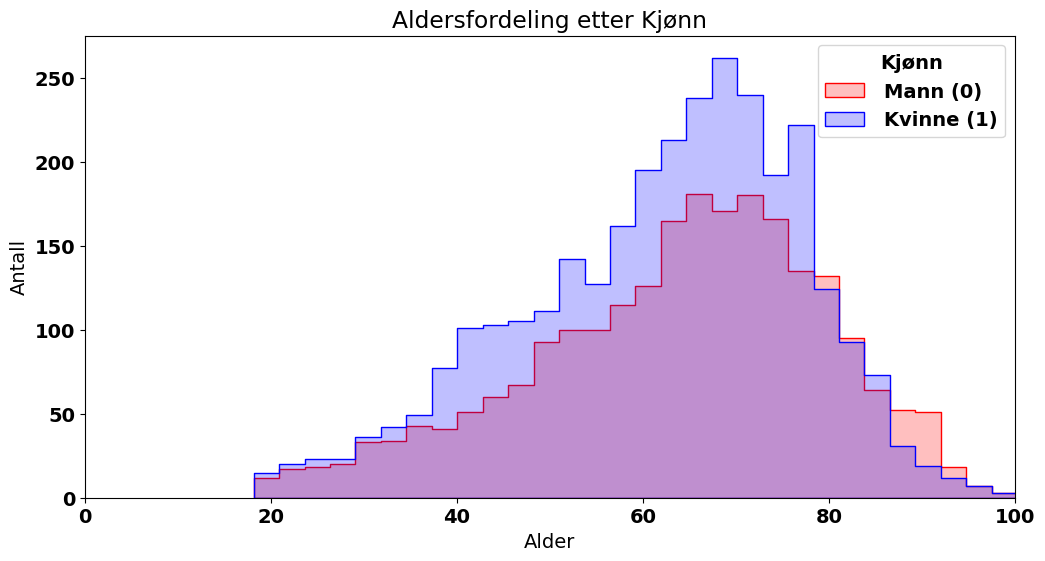

In [826]:
plt.figure(figsize=(12, 6))

sns.histplot(data=X_train, 
             x='alder', 
             hue=X_train['kjønn_female'].map({1: 'Kvinne', 0: 'Mann'}), 
             bins=30, 
             element='step', 
             stat='count', 
             common_norm=False, 
             palette={'Mann': 'blue', 'Kvinne': 'red'},
             hue_order=['Mann', 'Kvinne'])

plt.xlim(0, 100)

plt.title('Aldersfordeling etter Kjønn')
plt.xlabel('Alder')
plt.ylabel('Antall')

plt.legend(title='Kjønn', loc='upper right', labels=['Mann (0)', 'Kvinne (1)'], handletextpad=1, frameon=True)

plt.show()

#### Påvirker alder dødlighet?

Sektordiagrammet illustrerer dødlighet fordelt på aldersgrupper. Som forventet er dødligheten høyest blant de eldste pasientene. Det er imidlertid verdt å merke seg at forskjellen ikke er dramatisk store. Det kan tyde på at selv om alder er en faktor til dødlighet, er det andre variabler som også spiller en betydelig rolle. 

Vi undersøker videre for å forstå hvilke variabler dette er.

In [827]:
'''
alders_grupper = [-1, 20, 40, 60, 80, 100] 
navn_aldersgrupper = ['<20', '20-40', '40-60', '60-80', '>80']

X_train['alder_gruppe'] = pd.cut(X_train['alder'], bins=alders_grupper, labels=navn_aldersgrupper)

dode_per_aldergruppe = X_train.groupby('alder_gruppe')['sykehusdød'].mean() * 100

dode_df = dode_per_aldergruppe.reset_index()

fig = px.pie(dode_df, values='sykehusdød', names='alder_gruppe', title='Andel døde per aldersgruppe',
             color_discrete_sequence=px.colors.sequential.Plasma)

fig.update_traces(textinfo='label+percent')

fig.show()

X_train.drop(columns=['alder_gruppe'], inplace=True)
'''

"\nalders_grupper = [-1, 20, 40, 60, 80, 100] \nnavn_aldersgrupper = ['<20', '20-40', '40-60', '60-80', '>80']\n\nX_train['alder_gruppe'] = pd.cut(X_train['alder'], bins=alders_grupper, labels=navn_aldersgrupper)\n\ndode_per_aldergruppe = X_train.groupby('alder_gruppe')['sykehusdød'].mean() * 100\n\ndode_df = dode_per_aldergruppe.reset_index()\n\nfig = px.pie(dode_df, values='sykehusdød', names='alder_gruppe', title='Andel døde per aldersgruppe',\n             color_discrete_sequence=px.colors.sequential.Plasma)\n\nfig.update_traces(textinfo='label+percent')\n\nfig.show()\n\nX_train.drop(columns=['alder_gruppe'], inplace=True)\n"

#### Er ulike etnisiteter mer utsatt for enkelte sykdommer

Følgende funn er bemerkelsesverdige: 

* Det er en stor andel etnisitet_black som faller under sykdomskategori: sykdomskategori_COPD/CHF/Cirrhosis

* Det er en stor andel etnisitet_white som faller under sykdomskategori: sykdomskategori_cancer

* Det er en stor andel etnisitet_white som faller under sykdomskategori: sykdomskategori_coma

Dette er interessante funn, vi undersøker hva som kan være årsaken til disse funnene



#### Påvirker inntekt/velferd dødlighet (tilgang på bedre medisiner osv)?

Resultatet viser at inntekt ikke har stor innvirkning på overlevelse. 

In [828]:
'''
inntektskategorier = [col for col in X_train.columns if 'inntekt' in col]

resultater = []

for inntekt in inntektskategorier:
    
    total = X_train[X_train[inntekt] == 1].shape[0]
    
    if total > 0:
        dode = X_train[(X_train[inntekt] == 1) & (X_train['sykehusdød'] == 1)].shape[0]
        overlevende = X_train[(X_train[inntekt] == 1) & (X_train['sykehusdød'] == 0)].shape[0]
        
        dode_prosent = (dode / total) * 100
        overlevende_prosent = (overlevende / total) * 100
        
        resultater.append({'Inntektskategori': inntekt, 'Døde (%)': dode_prosent, 'Overlevende (%)': overlevende_prosent})

resultater_df = pd.DataFrame(resultater)

resultater_df = resultater_df.melt(id_vars='Inntektskategori', value_vars=['Døde (%)', 'Overlevende (%)'], 
                                    var_name='Status', value_name='Prosent')

plt.figure(figsize=(12, 6))
sns.barplot(data=resultater_df, x='Inntektskategori', y='Prosent', hue='Status', palette='viridis')
plt.title('Andel døde og overlevende basert på inntektskategori')
plt.xlabel('Inntektskategori')
plt.ylabel('Prosentandel (%)')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.legend(title='Status')
plt.show()
'''

"\ninntektskategorier = [col for col in X_train.columns if 'inntekt' in col]\n\nresultater = []\n\nfor inntekt in inntektskategorier:\n    \n    total = X_train[X_train[inntekt] == 1].shape[0]\n    \n    if total > 0:\n        dode = X_train[(X_train[inntekt] == 1) & (X_train['sykehusdød'] == 1)].shape[0]\n        overlevende = X_train[(X_train[inntekt] == 1) & (X_train['sykehusdød'] == 0)].shape[0]\n        \n        dode_prosent = (dode / total) * 100\n        overlevende_prosent = (overlevende / total) * 100\n        \n        resultater.append({'Inntektskategori': inntekt, 'Døde (%)': dode_prosent, 'Overlevende (%)': overlevende_prosent})\n\nresultater_df = pd.DataFrame(resultater)\n\nresultater_df = resultater_df.melt(id_vars='Inntektskategori', value_vars=['Døde (%)', 'Overlevende (%)'], \n                                    var_name='Status', value_name='Prosent')\n\nplt.figure(figsize=(12, 6))\nsns.barplot(data=resultater_df, x='Inntektskategori', y='Prosent', hue='Status', pal

In [829]:
X_train.columns

Index(['alder', 'utdanning', 'blodtrykk', 'hvite_blodlegemer',
       'hjertefrekvens', 'respirasjonsfrekvens', 'kroppstemperatur',
       'lungefunksjon', 'serumalbumin', 'kreatinin', 'natrium', 'blod_ph',
       'glukose', 'blodurea_nitrogen', 'urinmengde', 'antall_komorbiditeter',
       'koma_score', 'adl_stedfortreder', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens',
       'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd',
       'dnr_dag', 'kjønn_female', 'kjønn_male', 'inntekt_$11-$25k',
       'inntekt_$25-$50k', 'inntekt_>$50k', 'inntekt_under $11k',
       'inntekt_nan', 'etnisitet_asian', 'etnisitet_black',
       'etnisitet_hispanic', 'etnisitet_other', 'etnisitet_white',
       'etnisitet_nan', 'sykdomskategori_ARF/MOSF',
       'sykdomskategori_COPD/CHF/Cirrhosis', 'sykdomskategori_Cancer',
       'sykdomskategori_Coma', 'sykdom_underkategori_ARF/MOSF w/Sepsis',
  

## Visualisering (sykdomsrelaterte variabler)

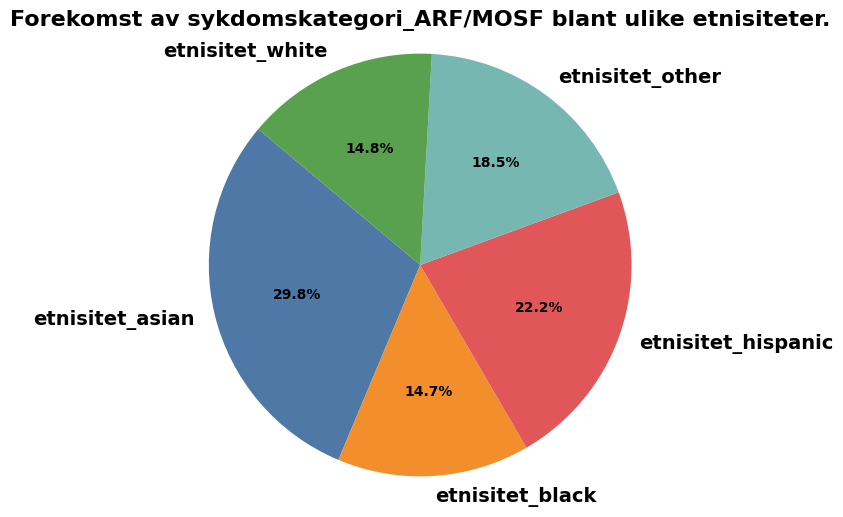

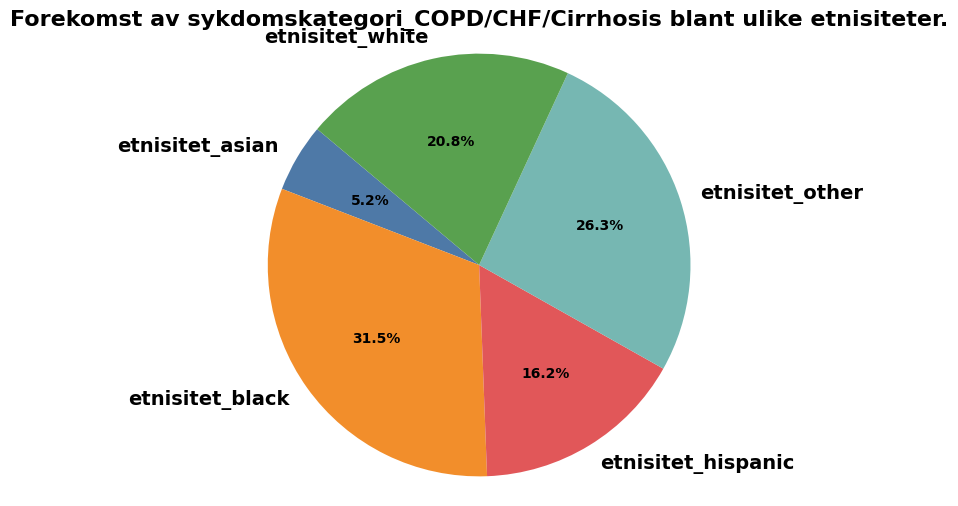

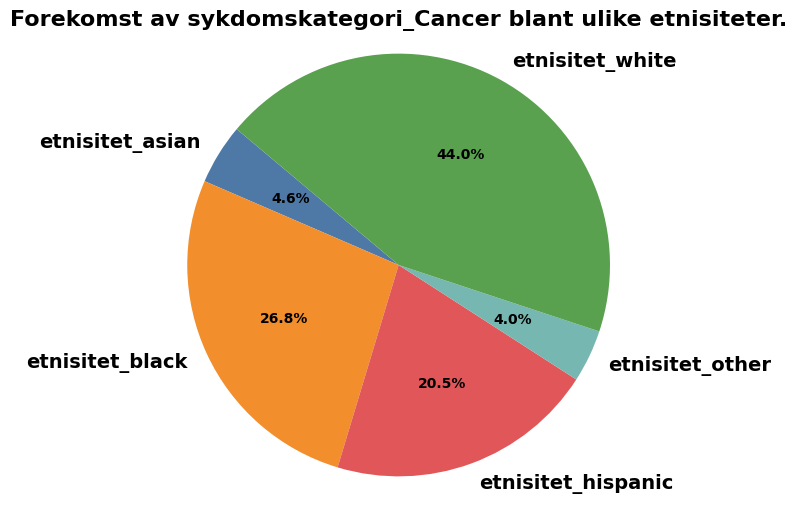

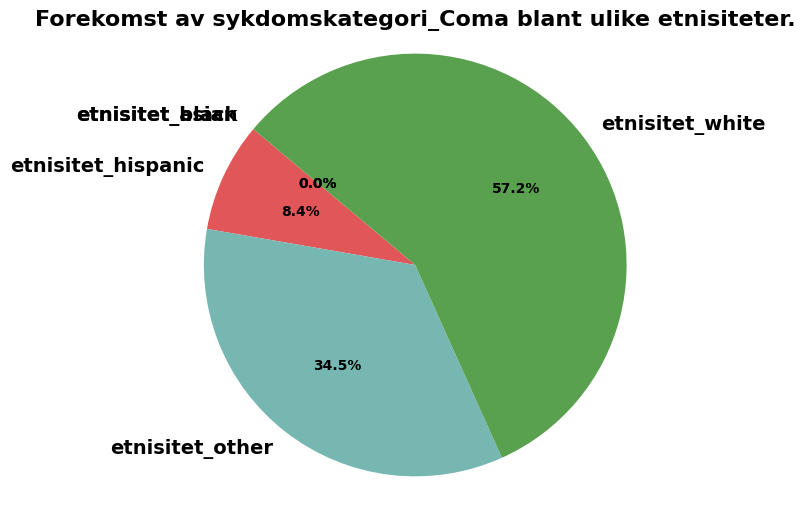

In [830]:
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']

ethnicities = ['etnisitet_asian', 'etnisitet_black', 'etnisitet_hispanic', 
               'etnisitet_other', 'etnisitet_white']
disease_categories = ['sykdomskategori_ARF/MOSF', 
                     'sykdomskategori_COPD/CHF/Cirrhosis', 
                     'sykdomskategori_Cancer', 
                     'sykdomskategori_Coma']

total_ethnicity_counts = X_train[ethnicities].sum()

plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'}) 

for disease in disease_categories:
    disease_data = X_train[X_train[disease] == 1][ethnicities].sum()

    percentage_data = (disease_data / total_ethnicity_counts) * 100
    
    plt.figure(figsize=(6, 6))
    
    wedges, texts, autotexts = plt.pie(percentage_data, labels=percentage_data.index, 
                                       autopct='%1.1f%%', startangle=140, 
                                       colors=colors, 
                                       textprops={'fontsize': 10})
    

    plt.title(f'Forekomst av {disease} blant ulike etnisiteter.', fontsize=16, fontweight='bold')
    

    plt.axis('equal') 
    
    for text in texts:
        text.set_fontsize(14)
        text.set_fontweight('bold')
    
    plt.show()

#### Korrelasjonsmatrise over kun fysiologisk faktorer

Oversikt over variabler tilknyttet fysiologiske variabler kan hjelpe med å diagnosere og behandle pasienter på sykehuset. Man får en oversikt over hvilke variabler som henger sammen.

Av de fysiologiske variablene ser vi tydelig at kreatinin og blodurea_nitrogen korrelerer sterkt. (Dette er fordi begge er avfallsprodukter som dannes under metabolismen av protein og muskler, og de gir viktig informasjon om nyrefunksjonen.)

Kreatinin og blod_ph har en sterk negativ korrelasjon fordi nrår nyrefunksjonen svekkes, akkumuleres kreatinin i blodet.

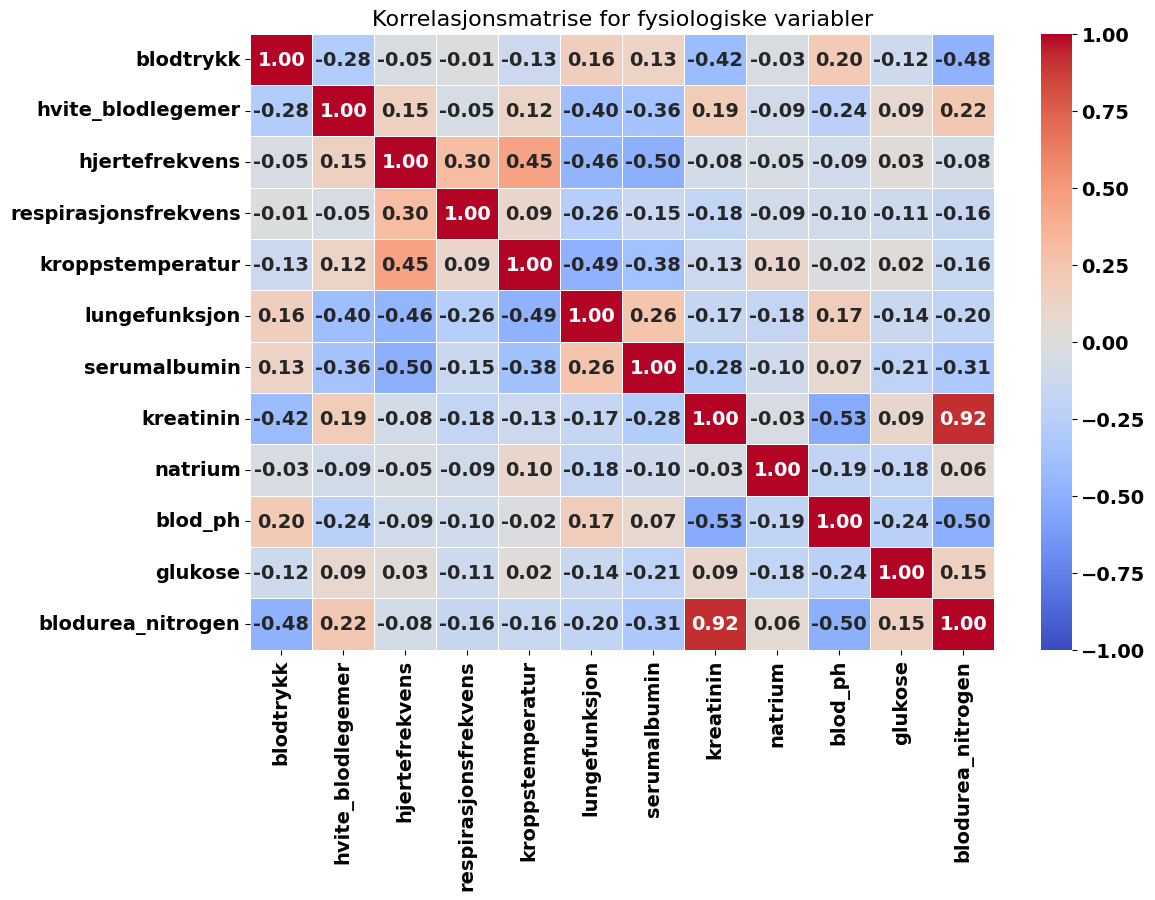

In [831]:
phychological_columns =  [
    'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens', 
    'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 
    'serumalbumin', 'kreatinin', 'natrium', 
    'blod_ph', 'glukose', 'blodurea_nitrogen'
]

korrelasjons_matrise = X_train[phychological_columns].corr()
korrelasjons_matrise = korrelasjons_matrise.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(korrelasjons_matrise, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Korrelasjonsmatrise for fysiologiske variabler', fontsize=16)
plt.show()

## Legger merke til at enkelte variabler under sykdomsalvorlighet korrelerer sterkt

* Fysiologisk score og apache_fysiologisk_score
* Lege overlevelsesestimat og overlevelsesestimat (vi dropper lege overlevelsesestimat)

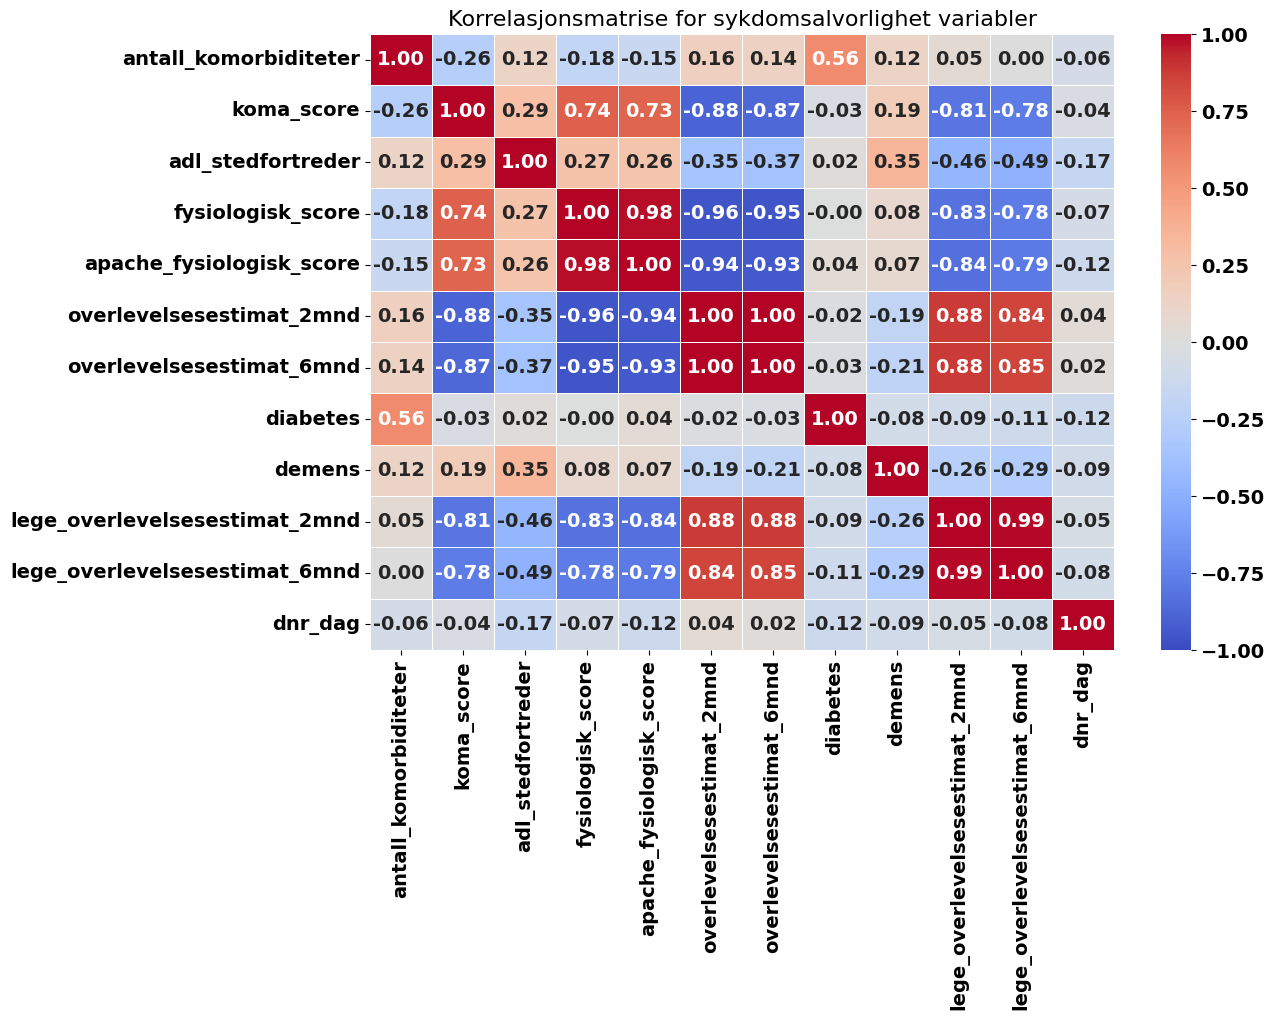

In [832]:
severity_columns = ['antall_komorbiditeter', 'koma_score',
       'adl_stedfortreder', 'fysiologisk_score', 'apache_fysiologisk_score',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens','lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'dnr_dag']

korrelasjons_matrise = X_train[severity_columns].corr()
korrelasjons_matrise = korrelasjons_matrise.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(korrelasjons_matrise, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title('Korrelasjonsmatrise for sykdomsalvorlighet variabler', fontsize=16)
plt.show()

In [833]:
severity_df.columns

Index(['sykdomskategori_id', 'sykdomskategori', 'dødsfall',
       'sykdom_underkategori', 'antall_komorbiditeter', 'koma_score',
       'adl_pasient', 'adl_stedfortreder', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens', 'kreft',
       'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd',
       'dnr_status', 'dnr_dag'],
      dtype='object')

## Korrelasjonsmatrise sykehusalvorlighet

In [834]:
df.columns

Index(['alder', 'kjønn', 'utdanning', 'inntekt', 'etnisitet', 'oppholdslengde',
       'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens',
       'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon',
       'serumalbumin', 'kreatinin', 'natrium', 'blod_ph', 'glukose',
       'blodurea_nitrogen', 'urinmengde', 'sykdomskategori',
       'sykdom_underkategori', 'antall_komorbiditeter', 'koma_score',
       'adl_stedfortreder', 'fysiologisk_score', 'apache_fysiologisk_score',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens', 'kreft', 'lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'dnr_status', 'dnr_dag'],
      dtype='object')

In [835]:
'''
plt.figure(figsize=(8, 6))
sns.boxplot(data=X_train, x='oppholdslengde', y='blodtrykk')
plt.title('Blodtrykk sammenlignet med dødelighet')
plt.xlabel('Dødelighet (0 = Overlevende, 1 = Død)')
plt.ylabel('Blodtrykk')
plt.show()
'''

"\nplt.figure(figsize=(8, 6))\nsns.boxplot(data=X_train, x='oppholdslengde', y='blodtrykk')\nplt.title('Blodtrykk sammenlignet med dødelighet')\nplt.xlabel('Dødelighet (0 = Overlevende, 1 = Død)')\nplt.ylabel('Blodtrykk')\nplt.show()\n"

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



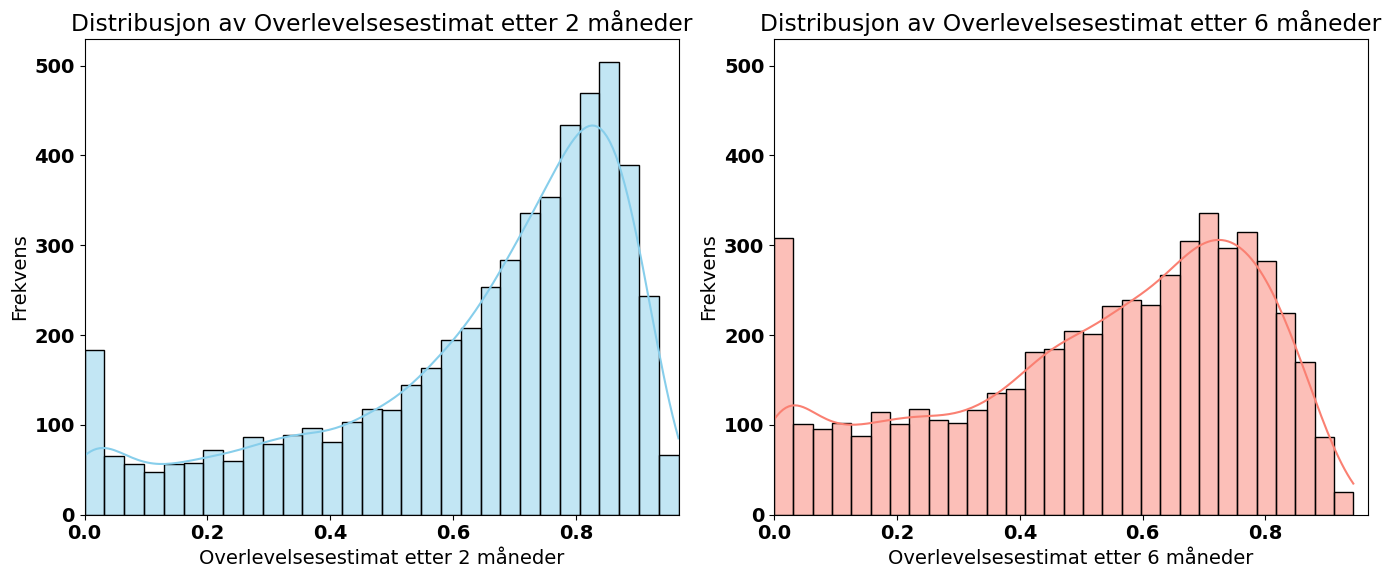

In [836]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(X_train['overlevelsesestimat_2mnd'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribusjon av Overlevelsesestimat etter 2 måneder')
axes[0].set_xlabel('Overlevelsesestimat etter 2 måneder')
axes[0].set_ylabel('Frekvens')

sns.histplot(X_train['overlevelsesestimat_6mnd'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribusjon av Overlevelsesestimat etter 6 måneder')
axes[1].set_xlabel('Overlevelsesestimat etter 6 måneder')
axes[1].set_ylabel('Frekvens')

x_limits = (min(X_train['overlevelsesestimat_2mnd'].min(), X_train['overlevelsesestimat_6mnd'].min()), 
            max(X_train['overlevelsesestimat_2mnd'].max(), X_train['overlevelsesestimat_6mnd'].max()))
y_limits = (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])) 

axes[0].set_xlim(x_limits)
axes[1].set_xlim(x_limits)
axes[0].set_ylim(y_limits)
axes[1].set_ylim(y_limits)

plt.tight_layout()
plt.show()

In [837]:
'''
plt.figure(figsize=(12, 6))


plt.subplot(1, 4, 1)
sns.boxplot(x='sykehusdød', y='blodtrykk', data=X_train)
plt.title('Blodtrykk etter Sykehusdød', fontsize=10)  
plt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize=10)
plt.ylabel('Blodtrykk', fontsize=10)


plt.subplot(1, 4, 2)
sns.boxplot(x='sykehusdød', y='hjertefrekvens', data=X_train)
plt.title('Hjertefrekvens etter Sykehusdød', fontsize=10)  
plt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize=10)
plt.ylabel('Hjertefrekvens', fontsize=10)


plt.subplot(1, 4, 3)
sns.boxplot(x='sykehusdød', y='respirasjonsfrekvens', data=X_train)
plt.title('Respirasjonsfrekvens etter Sykehusdød', fontsize=10)
plt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize=10)
plt.ylabel('Respirasjonsfrekvens', fontsize=10)

plt.subplot(1, 4, 4)
sns.boxplot(x='sykehusdød', y='kroppstemperatur', data=X_train)
plt.title('Kroppstemperatur etter Sykehusdød', fontsize=10)
plt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize=10)
plt.ylabel('Kroppstemperatur', fontsize=10)


plt.tight_layout()
plt.show()
'''

"\nplt.figure(figsize=(12, 6))\n\n\nplt.subplot(1, 4, 1)\nsns.boxplot(x='sykehusdød', y='blodtrykk', data=X_train)\nplt.title('Blodtrykk etter Sykehusdød', fontsize=10)  \nplt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize=10)\nplt.ylabel('Blodtrykk', fontsize=10)\n\n\nplt.subplot(1, 4, 2)\nsns.boxplot(x='sykehusdød', y='hjertefrekvens', data=X_train)\nplt.title('Hjertefrekvens etter Sykehusdød', fontsize=10)  \nplt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize=10)\nplt.ylabel('Hjertefrekvens', fontsize=10)\n\n\nplt.subplot(1, 4, 3)\nsns.boxplot(x='sykehusdød', y='respirasjonsfrekvens', data=X_train)\nplt.title('Respirasjonsfrekvens etter Sykehusdød', fontsize=10)\nplt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize=10)\nplt.ylabel('Respirasjonsfrekvens', fontsize=10)\n\nplt.subplot(1, 4, 4)\nsns.boxplot(x='sykehusdød', y='kroppstemperatur', data=X_train)\nplt.title('Kroppstemperatur etter Sykehusdød', fontsize=10)\nplt.xlabel('Sykehusdød (0=Overlevde, 1=Døde)', fontsize

#### Vi ønsker å finne ekstremalverdier for fysiologiske data

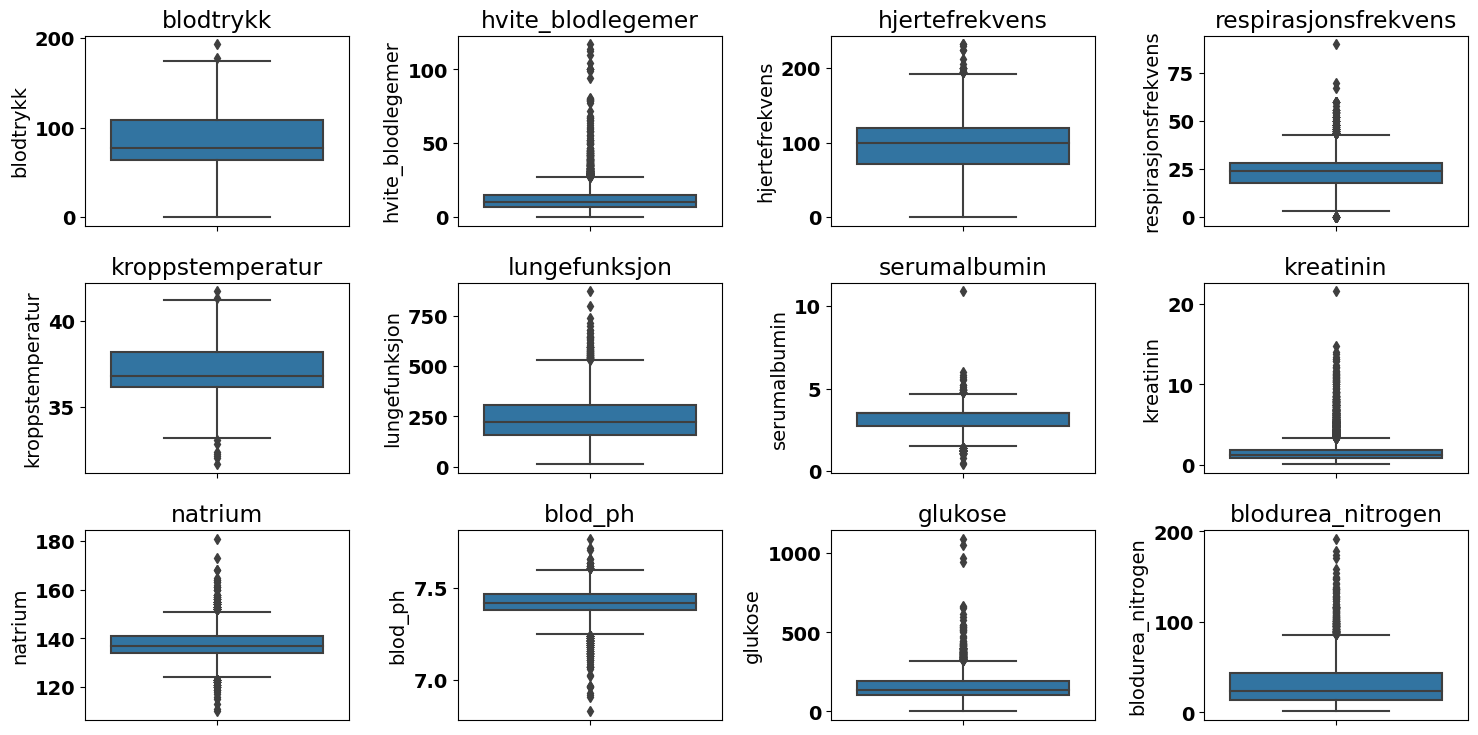

In [838]:
phychological_columns =  [
    'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens', 
    'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon', 
    'serumalbumin', 'kreatinin', 'natrium', 
    'blod_ph', 'glukose', 'blodurea_nitrogen'
]

plt.figure(figsize=(15, 10))
for i, column in enumerate(phychological_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=X_train, y=column)
    plt.title(column)
plt.tight_layout()
plt.show()

#### Sjekke for skjevhet

In [839]:
skewness = X_train.skew()
skewness


alder                                     -0.502309
utdanning                                  0.027797
blodtrykk                                  0.257757
hvite_blodlegemer                          3.859053
hjertefrekvens                             0.143335
respirasjonsfrekvens                       0.443794
kroppstemperatur                           0.294589
lungefunksjon                              0.835329
serumalbumin                              -0.273648
kreatinin                                  3.235624
natrium                                    0.385798
blod_ph                                   -1.083375
glukose                                    2.686572
blodurea_nitrogen                          1.702866
urinmengde                                 0.951643
antall_komorbiditeter                      0.798975
koma_score                                 2.359076
adl_stedfortreder                          1.223415
fysiologisk_score                          1.695327
apache_fysio

In [840]:
kurtosis = X_train.kurtosis()
kurtosis

alder                                      -0.169486
utdanning                                   1.633967
blodtrykk                                  -0.343785
hvite_blodlegemer                          27.414955
hjertefrekvens                              0.316157
respirasjonsfrekvens                        0.847131
kroppstemperatur                           -0.448888
lungefunksjon                               0.901902
serumalbumin                                2.859138
kreatinin                                  14.616859
natrium                                     1.811719
blod_ph                                     3.782106
glukose                                    15.470450
blodurea_nitrogen                           3.414526
urinmengde                                  5.025938
antall_komorbiditeter                       0.576321
koma_score                                  4.977340
adl_stedfortreder                           0.111210
fysiologisk_score                           6.

# Datarydding

Her må alle verdier som kan skape problemer for maskinlæringsmodellen fjernes. Det inkluderer: 

* Negative verdier
* Uteliggere --> behandles med medianverdier fordi robust mot uteliggere
* Sterkt korrelerende variabler
* Muligens NaN verdier (?) (både X_val og X_train, X_test inneholder ingen NaN verdier nå)
* Fjerne kolonner som ikke er relevante for å predikere oppholdslengde. Har funnet i visualiseringsdelen at utdanning ikke har ikke har stor innvirkning på sykdomskategori, derfor fjerner vi UTDANNING. Samme for ETNISITET, INNTEKT også
* Skaler data (standardscaler eller minmaxscaler)
* Fjerne mål fra dag 7 og utover, se: https://git.app.uib.no/inf161/prosjekt/-/blob/master/README.md?ref_type=heads (adl_pasient, bilirubin)
* Fjerne "Lege_overlevelsesestimat" fordi det korrelerer med "overlevelsesetstimat" --> vise vha korrelasjonsmatrise
* Slå sammen / fjerne èn av apache_fysiologisk_score og fysiologisk_score. Disse variablene er like og korrelerer sterkt

In [841]:
nan_counts = df[phychological_columns].isna().sum()

nan_counts = nan_counts[nan_counts > 0]

if not nan_counts.empty:
    print("NaN verdier funnet i følgende kolonner:")
    print(nan_counts)
else:
    print("Ingen NaN verdier funnet i spesifiserte kolonner.")


NaN verdier funnet i følgende kolonner:
lungefunksjon        1941
blod_ph              1909
glukose              3813
blodurea_nitrogen    3682
dtype: int64


#### Fant ved bruk at "lege_overlevelsesestimat" korrelerer sterkt med "overlevelsesestimat (2 mnd og 6 mdn). Vi fjerner derfor lege_overlevelsesestimat for å unngå "overfitting"

In [842]:

høyt_korrelerende_variabler = ["lege_overlevelsesestimat_2mnd", "lege_overlevelsesestimat_6mnd"]

X_train = X_train.drop(columns=høyt_korrelerende_variabler)
X_val = X_val.drop(columns=høyt_korrelerende_variabler)
X_test = X_test.drop(columns=høyt_korrelerende_variabler)

In [843]:
X_train.columns

Index(['alder', 'utdanning', 'blodtrykk', 'hvite_blodlegemer',
       'hjertefrekvens', 'respirasjonsfrekvens', 'kroppstemperatur',
       'lungefunksjon', 'serumalbumin', 'kreatinin', 'natrium', 'blod_ph',
       'glukose', 'blodurea_nitrogen', 'urinmengde', 'antall_komorbiditeter',
       'koma_score', 'adl_stedfortreder', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens', 'dnr_dag',
       'kjønn_female', 'kjønn_male', 'inntekt_$11-$25k', 'inntekt_$25-$50k',
       'inntekt_>$50k', 'inntekt_under $11k', 'inntekt_nan', 'etnisitet_asian',
       'etnisitet_black', 'etnisitet_hispanic', 'etnisitet_other',
       'etnisitet_white', 'etnisitet_nan', 'sykdomskategori_ARF/MOSF',
       'sykdomskategori_COPD/CHF/Cirrhosis', 'sykdomskategori_Cancer',
       'sykdomskategori_Coma', 'sykdom_underkategori_ARF/MOSF w/Sepsis',
       'sykdom_underkategori_CHF', 'sykdom_underkategori_COPD',
       'sykdom_und

#### Ikke mulig å ha null i hjertefrekvens og puste samtidig

In [844]:
'''
betingelse_train = (X_train["hjertefrekvens"] == 0) & (X_train["lungefunksjon"] != 0)
betingelse_val = (X_val["hjertefrekvens"] == 0) & (X_val["lungefunksjon"] != 0)
betingelse_test = (X_test["hjertefrekvens"] == 0) & (X_test["lungefunksjon"] != 0)

null_i_hjertefrekvens_og_puster = betingelse_train.sum()
print(f'Det er {null_i_hjertefrekvens_og_puster} som har null i hjertefrekvens og puster samtidig')

if null_i_hjertefrekvens_og_puster > 0:
    X_train.loc[betingelse_train, :] = np.nan

if null_i_hjertefrekvens_og_puster > 0:
    X_val.loc[betingelse_val, :]  = np.nan

if null_i_hjertefrekvens_og_puster > 0:
    X_test.loc[betingelse_test, :]  = np.nan
'''

'\nbetingelse_train = (X_train["hjertefrekvens"] == 0) & (X_train["lungefunksjon"] != 0)\nbetingelse_val = (X_val["hjertefrekvens"] == 0) & (X_val["lungefunksjon"] != 0)\nbetingelse_test = (X_test["hjertefrekvens"] == 0) & (X_test["lungefunksjon"] != 0)\n\nnull_i_hjertefrekvens_og_puster = betingelse_train.sum()\nprint(f\'Det er {null_i_hjertefrekvens_og_puster} som har null i hjertefrekvens og puster samtidig\')\n\nif null_i_hjertefrekvens_og_puster > 0:\n    X_train.loc[betingelse_train, :] = np.nan\n\nif null_i_hjertefrekvens_og_puster > 0:\n    X_val.loc[betingelse_val, :]  = np.nan\n\nif null_i_hjertefrekvens_og_puster > 0:\n    X_test.loc[betingelse_test, :]  = np.nan\n'

In [845]:
# Regn ut antall NaN-verdier for hver kolonne
nan_counts = X_train.isna().sum()

# Skriv ut antall NaN-verdier per kolonne
for kolonne, antall_nan in nan_counts.items():
    print(f'Antall NaN-verdier i kolonnen "{kolonne}": {antall_nan}')

X_train.head()

Antall NaN-verdier i kolonnen "alder": 0
Antall NaN-verdier i kolonnen "utdanning": 977
Antall NaN-verdier i kolonnen "blodtrykk": 0
Antall NaN-verdier i kolonnen "hvite_blodlegemer": 0
Antall NaN-verdier i kolonnen "hjertefrekvens": 0
Antall NaN-verdier i kolonnen "respirasjonsfrekvens": 0
Antall NaN-verdier i kolonnen "kroppstemperatur": 0
Antall NaN-verdier i kolonnen "lungefunksjon": 1355
Antall NaN-verdier i kolonnen "serumalbumin": 0
Antall NaN-verdier i kolonnen "kreatinin": 0
Antall NaN-verdier i kolonnen "natrium": 0
Antall NaN-verdier i kolonnen "blod_ph": 1330
Antall NaN-verdier i kolonnen "glukose": 2667
Antall NaN-verdier i kolonnen "blodurea_nitrogen": 2572
Antall NaN-verdier i kolonnen "urinmengde": 0
Antall NaN-verdier i kolonnen "antall_komorbiditeter": 0
Antall NaN-verdier i kolonnen "koma_score": 0
Antall NaN-verdier i kolonnen "adl_stedfortreder": 1685
Antall NaN-verdier i kolonnen "fysiologisk_score": 0
Antall NaN-verdier i kolonnen "apache_fysiologisk_score": 0
An

,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,dnr_dag,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,inntekt_nan,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,etnisitet_nan,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,dnr_status_None
0,77.91394,14.0,133.0,22.097656,141.0,42.0,36.69531,186.65625,3.299805,0.699951,125.0,7.399414,159.0,16.0,1316.0,3,0.0,0.0,25.398438,36.0,0.765991,0.628906,0,0,NaN,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,63.10199,NaN,97.0,4.299805,50.0,16.0,35.79688,238.09375,3.099609,2.500000,146.0,7.289062,64.0,71.0,1535.0,4,9.0,2.0,16.796875,29.0,0.819946,0.707886,0,1,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,66.98199,14.0,41.0,13.500000,0.0,26.0,38.19531,137.00000,3.500000,2.599609,137.0,6.929688,543.0,40.0,140.0,3,0.0,7.0,22.500000,45.0,0.855957,0.761963,0,0,NaN,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,66.59296,8.0,76.0,6.500000,84.0,24.0,36.39844,533.25000,3.699707,1.599854,139.0,7.479492,NaN,NaN,2502.0,1,26.0,0.0,26.898438,35.0,0.736938,0.654907,0,0,NaN,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4,74.36798,NaN,57.0,11.099609,70.0,28.0,36.69531,412.00000,2.799805,1.699951,143.0,7.339844,NaN,NaN,2502.0,4,0.0,NaN,58.398438,103.0,0.001000,0.000000,1,0,NaN,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


#### Fjerner NaN verdier får vi lager modeller (bytter med median)

In [846]:

'''
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Kopier datasett
X_train_without_nan = X_train.copy()
X_val_without_nan = X_val.copy()
X_test_without_nan = X_test.copy()

# Initialiser IterativeImputer (MICE)
mice_imputer = IterativeImputer(random_state=0)

# Fyll NaN-verdier i X_train
X_train_without_nan_imputed = mice_imputer.fit_transform(X_train_without_nan)

# Fyll NaN-verdier i X_val
X_val_without_nan_imputed = mice_imputer.transform(X_val_without_nan)

# Fyll NaN-verdier i X_test
X_test_without_nan_imputed = mice_imputer.transform(X_test_without_nan)

# Konverter tilbake til DataFrame
X_train_without_nan = pd.DataFrame(X_train_without_nan_imputed, columns=X_train.columns)
X_val_without_nan = pd.DataFrame(X_val_without_nan_imputed, columns=X_val.columns)
X_test_without_nan = pd.DataFrame(X_test_without_nan_imputed, columns=X_test.columns)

# Bekrefte at det ikke finnes NaN-verdier igjen i datasett
print(f'Antall NaN-verdier i X_train_without_nan etter MICE-fylling: {X_train_without_nan.isnull().sum().sum()}')
print(f'Antall NaN-verdier i X_val_without_nan etter MICE-fylling: {X_val_without_nan.isnull().sum().sum()}')
print(f'Antall NaN-verdier i X_test_without_nan etter MICE-fylling: {X_test_without_nan.isnull().sum().sum()}')
'''


X_train_without_nan = X_train.copy()
X_val_without_nan = X_val.copy()
X_test_without_nan = X_test.copy()

# Liste over kolonner med NaN-verdier
nan_columns = [
    'pasient_id', 'alder', 'utdanning', 'sykehusdød', 'blodtrykk',
    'hvite_blodlegemer', 'hjertefrekvens', 'respirasjonsfrekvens',
    'kroppstemperatur', 'lungefunksjon', 'serumalbumin',
    'kreatinin', 'natrium', 'blod_ph', 'glukose', 'blodurea_nitrogen',
    'urinmengde', 'dødsfall', 'antall_komorbiditeter', 'koma_score',
    'adl_pasient', 'adl_stedfortreder', 'fysiologisk_score',
    'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
    'overlevelsesestimat_6mnd', 'diabetes', 'demens',
    'dnr_dag', 'kjønn_female', 'kjønn_male', 'inntekt_$11-$25k',
    'inntekt_$25-$50k', 'inntekt_>$50k', 'inntekt_under $11k',
    'inntekt_nan', 'etnisitet_asian', 'etnisitet_black',
    'etnisitet_hispanic', 'etnisitet_other', 'etnisitet_white',
    'etnisitet_nan', 'sykdomskategori_ARF/MOSF',
    'sykdomskategori_COPD/CHF/Cirrhosis', 'sykdomskategori_Cancer',
    'sykdomskategori_Coma', 'sykdom_underkategori_ARF/MOSF w/Sepsis',
    'sykdom_underkategori_CHF', 'sykdom_underkategori_COPD',
    'sykdom_underkategori_Cirrhosis', 'sykdom_underkategori_Colon Cancer',
    'sykdom_underkategori_Coma', 'sykdom_underkategori_Lung Cancer',
    'sykdom_underkategori_MOSF w/Malig', 'kreft_metastatic', 'kreft_no',
    'kreft_yes', 'dnr_status_dnr før innleggelse',
    'dnr_status_dnr ved innleggelse', 'dnr_status_None'
]

# Fyll NaN-verdier i X_train
for kolonne in nan_columns:
    if kolonne in X_train_without_nan.columns:
        mean_verdi = X_train_without_nan[kolonne].median()
        # Sjekk om meanen er NaN
        if pd.notna(mean_verdi):
            X_train_without_nan[kolonne].fillna(mean_verdi, inplace=True)

# Fyll NaN-verdier i X_val basert på meanen fra X_train
for kolonne in nan_columns:
    if kolonne in X_val_without_nan.columns:
        mean_verdi = X_train_without_nan[kolonne].median()
        # Sjekk om meanen er NaN
        if pd.notna(mean_verdi):
            X_val_without_nan[kolonne].fillna(mean_verdi, inplace=True)

for kolonne in nan_columns:
    if kolonne in X_test_without_nan.columns:
        mean_verdi = X_train_without_nan[kolonne].median()
        # Sjekk om meanen er NaN
        if pd.notna(mean_verdi):
            X_test_without_nan[kolonne].fillna(mean_verdi, inplace=True)

# Bekrefte at det ikke finnes NaN-verdier igjen i datasett
print(f'Antall NaN-verdier i X_train_without_nan etter fylling: {X_train_without_nan.isnull().sum().sum()}')
print(f'Antall NaN-verdier i X_val_without_nan etter fylling: {X_val_without_nan.isnull().sum().sum()}')
print(f'Antall NaN-verdier i X_test_without_nan etter fylling: {X_test_without_nan.isnull().sum().sum()}')


Antall NaN-verdier i X_train_without_nan etter fylling: 0
Antall NaN-verdier i X_val_without_nan etter fylling: 0
Antall NaN-verdier i X_test_without_nan etter fylling: 0


C:\Users\andre\AppData\Local\Temp\ipykernel_25196\3392266437.py:71: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\andre\AppData\Local\Temp\ipykernel_25196\3392266437.py:71: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

# Del 2 - modellering

In [847]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [848]:
X_train_without_nan.head(5)

,alder,utdanning,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,dnr_dag,kjønn_female,kjønn_male,inntekt_$11-$25k,inntekt_$25-$50k,inntekt_>$50k,inntekt_under $11k,inntekt_nan,etnisitet_asian,etnisitet_black,etnisitet_hispanic,etnisitet_other,etnisitet_white,etnisitet_nan,sykdomskategori_ARF/MOSF,sykdomskategori_COPD/CHF/Cirrhosis,sykdomskategori_Cancer,sykdomskategori_Coma,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft_metastatic,kreft_no,kreft_yes,dnr_status_dnr før innleggelse,dnr_status_dnr ved innleggelse,dnr_status_None
0,77.91394,14.0,133.0,22.097656,141.0,42.0,36.69531,186.65625,3.299805,0.699951,125.0,7.399414,159.0,16.0,1316.0,3,0.0,0.0,25.398438,36.0,0.765991,0.628906,0,0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,63.10199,12.0,97.0,4.299805,50.0,16.0,35.79688,238.09375,3.099609,2.500000,146.0,7.289062,64.0,71.0,1535.0,4,9.0,2.0,16.796875,29.0,0.819946,0.707886,0,1,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,66.98199,14.0,41.0,13.500000,0.0,26.0,38.19531,137.00000,3.500000,2.599609,137.0,6.929688,543.0,40.0,140.0,3,0.0,7.0,22.500000,45.0,0.855957,0.761963,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,66.59296,8.0,76.0,6.500000,84.0,24.0,36.39844,533.25000,3.699707,1.599854,139.0,7.479492,134.0,24.0,2502.0,1,26.0,0.0,26.898438,35.0,0.736938,0.654907,0,0,0.0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4,74.36798,12.0,57.0,11.099609,70.0,28.0,36.69531,412.00000,2.799805,1.699951,143.0,7.339844,134.0,24.0,2502.0,4,0.0,1.0,58.398438,103.0,0.001000,0.000000,1,0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [849]:
print("Antall NaN-verdier per kolonne i X_train_without_nan:")
print(X_train_without_nan.isnull().sum())

# For X_val_without_nan
#print("\nAntall NaN-verdier per kolonne i X_val_without_nan:")
#print(X_val_without_nan.isnull().sum())

Antall NaN-verdier per kolonne i X_train_without_nan:
alder                                     0
utdanning                                 0
blodtrykk                                 0
hvite_blodlegemer                         0
hjertefrekvens                            0
respirasjonsfrekvens                      0
kroppstemperatur                          0
lungefunksjon                             0
serumalbumin                              0
kreatinin                                 0
natrium                                   0
blod_ph                                   0
glukose                                   0
blodurea_nitrogen                         0
urinmengde                                0
antall_komorbiditeter                     0
koma_score                                0
adl_stedfortreder                         0
fysiologisk_score                         0
apache_fysiologisk_score                  0
overlevelsesestimat_2mnd                  0
overlevelsesestimat_6m

In [850]:

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# Initialize results list
results = []

# 1. Linear Regression
model_lr = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model_lr.fit(X_train_without_nan, y_train)
pred_lr = model_lr.predict(X_val_without_nan)
rmse_lr = np.round(np.sqrt(mean_squared_error(y_val, pred_lr)), decimals=2)
results.append(('Linear Regression', rmse_lr))

# 2. Ridge Regression
model_ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0))
model_ridge.fit(X_train_without_nan, y_train)
pred_ridge = model_ridge.predict(X_val_without_nan)
rmse_ridge = np.round(np.sqrt(mean_squared_error(y_val, pred_ridge)), decimals=2)
results.append(('Ridge Regression', rmse_ridge))

# 3. Lasso Regression
model_lasso = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.1))
model_lasso.fit(X_train_without_nan, y_train)
pred_lasso = model_lasso.predict(X_val_without_nan)
rmse_lasso = np.round(np.sqrt(mean_squared_error(y_val, pred_lasso)), decimals=2)
results.append(('Lasso Regression', rmse_lasso))

# 4. Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_without_nan, y_train)
pred_rf = model_rf.predict(X_val_without_nan)
rmse_rf = np.round(np.sqrt(mean_squared_error(y_val, pred_rf)), decimals=2)
results.append(('Random Forest', rmse_rf))

# 5. Gradient Boosting Regressor
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train_without_nan, y_train)
pred_gb = model_gb.predict(X_val_without_nan)
rmse_gb = np.round(np.sqrt(mean_squared_error(y_val, pred_gb)), decimals=2)
results.append(('Gradient Boosting', rmse_gb))

# 6. Support Vector Regressor
model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model_svr.fit(X_train_without_nan, y_train)
pred_svr = model_svr.predict(X_val_without_nan)
rmse_svr = np.round(np.sqrt(mean_squared_error(y_val, pred_svr)), decimals=2)
results.append(('Support Vector Regressor', rmse_svr))

# 7. K-Nearest Neighbors Regressor
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_without_nan, y_train)
pred_knn = model_knn.predict(X_val_without_nan)
rmse_knn = np.round(np.sqrt(mean_squared_error(y_val, pred_knn)), decimals=2)
results.append(('K-Nearest Neighbors', rmse_knn))

# 8. Decision Tree Regressor
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train_without_nan, y_train)
pred_dt = model_dt.predict(X_val_without_nan)
rmse_dt = np.round(np.sqrt(mean_squared_error(y_val, pred_dt)), decimals=2)
results.append(('Decision Tree', rmse_dt))

# 9. Elastic Net
model_en = make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=0.1, l1_ratio=0.5))
model_en.fit(X_train_without_nan, y_train)
pred_en = model_en.predict(X_val_without_nan)
rmse_en = np.round(np.sqrt(mean_squared_error(y_val, pred_en)), decimals=2)
results.append(('Elastic Net', rmse_en))

# Print the results
for model_name, rmse in results:
    print(f'{model_name}: RMSE = {rmse}')



C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=1.17651e-18): result may not be accurate.

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e+06, tolerance: 2.486e+02



Linear Regression: RMSE = 36.52
Ridge Regression: RMSE = 32.79
Lasso Regression: RMSE = 19.67
Random Forest: RMSE = 19.26
Gradient Boosting: RMSE = 18.78
Support Vector Regressor: RMSE = 19.44
K-Nearest Neighbors: RMSE = 20.22
Decision Tree: RMSE = 26.64
Elastic Net: RMSE = 19.81


C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+06, tolerance: 2.486e+02



In [851]:
# # Sjekk funksjonsnavnene i treningssettet
# print("Funksjonsnavn i X_train_without_nan:")
# print(X_train_without_nan.columns.tolist())

# # Sjekk funksjonsnavnene i valideringssettet
# print("Funksjonsnavn i X_val:")
# print(X_val_without_nan.columns.tolist())

# print("Funksjonsnavn i X_val:")
# print(X_test_without_nan.columns.tolist())

# if X_train_without_nan.columns.to_list() == X_val_without_nan.columns.tolist() == X_test_without_nan.columns.tolist():
#   print("Yes")
# else:
#   print("No")

a = y_train.mean()
print(a)
# X_train_without_nan.shape
# X_val_without_nan.shape
# X_test_without_nan.shape

17.909242144177448
